# Assignment 7.1 - Word2Vec

In this task, we will train our word vectors on a small dataset.
We will use the simplest version of word2vec, without negative sampling or other optimizations.

Before starting, you need to run the `download_data.sh` script to download the data.

The dataset and model are very small, so this task can be performed without a GPU.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, repeat
from tqdm import tqdm

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [2]:
class StanfordTreeBank:
    """
    Wrapper for accessing Stanford Tree Bank Dataset. 
    
    See link: https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    """
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
unnecessary ['goldmember', 'some', 'places']
simone ['funky', 'an']
yearning ['unruly', 'boy', 'adventure', 'worth']
seamless ['cast', 'who']
regurgitated ['action', 'dead']


# Implementing PyTorch-style Dataset for Word2Vec

This Dataset should generate a lot of random contexts and turn them into samples for training.

As a reminder, the word2vec model takes a One-hot word vector as input and trains a simple network to predict nearest words based on it.

From the set word-context, N samples are created (where N is the number of words in the context):

For example:
Word: `orders` and context: `['love', 'nicest', 'to', '50-year']` generates 4 samples:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

All words at the input and at the output are encoded through one-hot encoding, with a vector size equal to the number of tokens.

In [3]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts=30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        # TODO: Implement what you need for other methods!
        self.data = data
        self.num_contexts = num_contexts
        self.samples = []

    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        self.samples = []
        
        for _ in range(self.num_contexts):
            center_word, other_words = self.data.get_random_context(5)
            input_idx = self.data.index_by_token[center_word]
            output_indices = [self.data.index_by_token[word] for word in other_words]

            self.samples.extend(product(repeat(input_idx, len(output_indices)), output_indices))
            
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        # TODO: Return the number of samples
        return len(self.samples)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        # TODO: Generate tuple of 2 return arguments for i-th sample 
        input_idx, target_idx = self.samples[index]

        input_vector = torch.zeros(self.data.num_tokens(), 1)
        input_vector.scatter_(0, torch.tensor([[input_idx]]), 1)
        
        return input_vector, target_idx

dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]), target: 1814


# Create a model and train it

In [4]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(data.num_tokens(), wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, data.num_tokens(), bias=False), 
         )

In [5]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos 
    # Hint: you can access weights as Tensors through nn.Linear class attributes
    return torch.transpose(nn_model[0].weight.data.clone(), 0, 1), nn_model[1].weight.data.clone()

    
untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [6]:
def train_model(model, train_loader, optimizer, scheduler, num_epochs, device):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    
    loss = nn.CrossEntropyLoss()
    
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        train_loader.dataset.generate_dataset() # Regenerate dataset every epoch
       
        print(len(train_loader.dataset))
        
        # TODO Implement training for this model
        # Note we don't have any validation set here because our purpose is the word vectors,
        # not the predictive performance of the model
        #
        # And don't forget to step the learing rate scheduler!  
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
            optimizer.zero_grad()
            
            x, y = x.to(device), y.to(device)
            prediction = model(x.view(x.shape[0], -1))    
            loss_value = loss(prediction, y)
            
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = correct_samples.to(dtype=torch.float) / total_samples
        
        loss_history.append(float(ave_loss.cpu().item()))
        train_history.append(train_accuracy.cpu().item())
        
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# And finally a training

Achieve error values less than ** 8.0 **.

In [7]:
# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(data.num_tokens(), wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, data.num_tokens(), bias=False), 
         )


In [8]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.AdamW(nn_model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=4)

device = torch.device('cuda:0')
nn_model = nn_model.to(device)

loss_history, train_history = train_model(nn_model, train_loader, optimizer, scheduler, 50, device)

248084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:10<00:00, 45.84it/s]


Epoch 0, Average loss: 9.832137, Train accuracy: 0.000959
248778


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:10<00:00, 45.94it/s]


Epoch 1, Average loss: 9.688511, Train accuracy: 0.002705
248442


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:10<00:00, 45.59it/s]


Epoch 2, Average loss: 9.551596, Train accuracy: 0.003035
248811


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:10<00:00, 46.84it/s]


Epoch 3, Average loss: 9.417654, Train accuracy: 0.004148
250372


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:10<00:00, 47.24it/s]


Epoch 4, Average loss: 9.291549, Train accuracy: 0.005735
247897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:10<00:00, 47.55it/s]


Epoch 5, Average loss: 9.178068, Train accuracy: 0.007741
248267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:11<00:00, 43.96it/s]


Epoch 6, Average loss: 9.056755, Train accuracy: 0.009566
248388


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:11<00:00, 43.73it/s]


Epoch 7, Average loss: 8.950653, Train accuracy: 0.011671
248131


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:10<00:00, 47.08it/s]


Epoch 8, Average loss: 8.844394, Train accuracy: 0.013731
248375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:11<00:00, 44.17it/s]


Epoch 9, Average loss: 8.751870, Train accuracy: 0.015155
248827


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:11<00:00, 43.66it/s]


Epoch 10, Average loss: 8.674870, Train accuracy: 0.017076
248058


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:11<00:00, 43.12it/s]


Epoch 11, Average loss: 8.620306, Train accuracy: 0.018484
249305


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 487/487 [00:10<00:00, 46.23it/s]


Epoch 12, Average loss: 8.557464, Train accuracy: 0.020433
247841


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:10<00:00, 47.83it/s]


Epoch 13, Average loss: 8.507532, Train accuracy: 0.020892
248682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:10<00:00, 47.48it/s]


Epoch 14, Average loss: 8.434563, Train accuracy: 0.022072
247883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:10<00:00, 46.82it/s]


Epoch 15, Average loss: 8.365765, Train accuracy: 0.024596
248230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:10<00:00, 46.90it/s]


Epoch 16, Average loss: 8.290808, Train accuracy: 0.027003
248222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:10<00:00, 47.21it/s]


Epoch 17, Average loss: 8.249025, Train accuracy: 0.027580
249520


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 488/488 [00:10<00:00, 47.26it/s]


Epoch 18, Average loss: 8.212058, Train accuracy: 0.027861
249500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 488/488 [00:10<00:00, 45.78it/s]


Epoch 19, Average loss: 8.155110, Train accuracy: 0.029355
247691


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484/484 [00:11<00:00, 43.33it/s]


Epoch 20, Average loss: 8.142905, Train accuracy: 0.029783
247604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484/484 [00:11<00:00, 43.77it/s]


Epoch 21, Average loss: 8.123342, Train accuracy: 0.030945
248392


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:11<00:00, 43.36it/s]


Epoch 22, Average loss: 8.124587, Train accuracy: 0.029941
249453


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 488/488 [00:11<00:00, 43.49it/s]


Epoch 23, Average loss: 8.084304, Train accuracy: 0.031128
248049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:10<00:00, 47.17it/s]


Epoch 24, Average loss: 8.036535, Train accuracy: 0.032187
249422


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 488/488 [00:10<00:00, 47.19it/s]


Epoch 25, Average loss: 8.020632, Train accuracy: 0.031497
247286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 483/483 [00:10<00:00, 43.98it/s]


Epoch 26, Average loss: 8.050037, Train accuracy: 0.030944
247953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:11<00:00, 43.70it/s]


Epoch 27, Average loss: 7.966326, Train accuracy: 0.033611
249258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 487/487 [00:10<00:00, 46.87it/s]


Epoch 28, Average loss: 7.949393, Train accuracy: 0.034013
247970


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:10<00:00, 47.62it/s]


Epoch 29, Average loss: 7.957466, Train accuracy: 0.034129
249844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 488/488 [00:10<00:00, 47.26it/s]


Epoch 30, Average loss: 7.977596, Train accuracy: 0.034201
247435


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484/484 [00:11<00:00, 43.73it/s]


Epoch 31, Average loss: 7.896485, Train accuracy: 0.036915
248693


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:11<00:00, 43.90it/s]


Epoch 32, Average loss: 7.913280, Train accuracy: 0.036008
247529


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484/484 [00:11<00:00, 43.54it/s]


Epoch 33, Average loss: 7.884434, Train accuracy: 0.036101
246584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 482/482 [00:11<00:00, 40.74it/s]


Epoch 34, Average loss: 7.873622, Train accuracy: 0.037229
248942


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 487/487 [00:11<00:00, 42.10it/s]


Epoch 35, Average loss: 7.857772, Train accuracy: 0.037093
246775


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 482/482 [00:13<00:00, 36.49it/s]


Epoch 36, Average loss: 7.835549, Train accuracy: 0.037297
247518


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484/484 [00:12<00:00, 37.87it/s]


Epoch 37, Average loss: 7.831134, Train accuracy: 0.037828
247852


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:13<00:00, 35.41it/s]


Epoch 38, Average loss: 7.826388, Train accuracy: 0.038148
248250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:13<00:00, 34.74it/s]


Epoch 39, Average loss: 7.803173, Train accuracy: 0.038433
249273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 487/487 [00:13<00:00, 36.54it/s]


Epoch 40, Average loss: 7.800181, Train accuracy: 0.038307
248211


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:12<00:00, 37.89it/s]


Epoch 41, Average loss: 7.798306, Train accuracy: 0.039011
250144


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 489/489 [00:12<00:00, 39.85it/s]


Epoch 42, Average loss: 7.790632, Train accuracy: 0.037426
249036


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 487/487 [00:13<00:00, 36.51it/s]


Epoch 43, Average loss: 7.766439, Train accuracy: 0.038091
247667


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484/484 [00:13<00:00, 36.45it/s]


Epoch 44, Average loss: 7.766650, Train accuracy: 0.039505
246703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 482/482 [00:13<00:00, 36.86it/s]


Epoch 45, Average loss: 7.763664, Train accuracy: 0.039732
248354


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:13<00:00, 35.65it/s]


Epoch 46, Average loss: 7.761444, Train accuracy: 0.039085
248713


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:13<00:00, 35.83it/s]


Epoch 47, Average loss: 7.744363, Train accuracy: 0.039463
249555


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 488/488 [00:13<00:00, 35.67it/s]


Epoch 48, Average loss: 7.756981, Train accuracy: 0.038376
248566


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:12<00:00, 37.40it/s]

Epoch 49, Average loss: 7.738577, Train accuracy: 0.041035


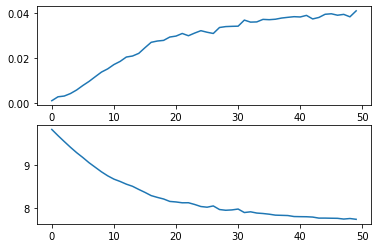

In [9]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Visualizing vectors for different kinds of words before and after training

In case of successful training, you should see how vectors of words of different types (for example, punctuation marks, prepositions, and others) are separated semantically.

Students - send a notebook with diagrams as a completed assignment!

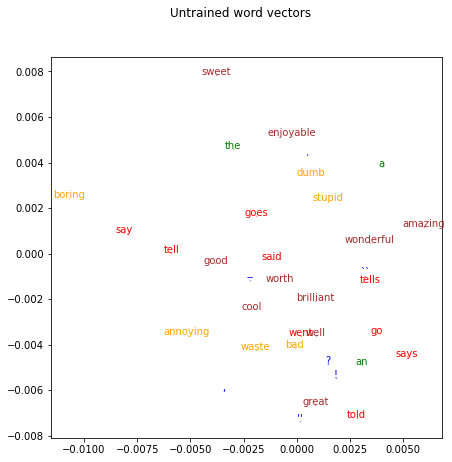

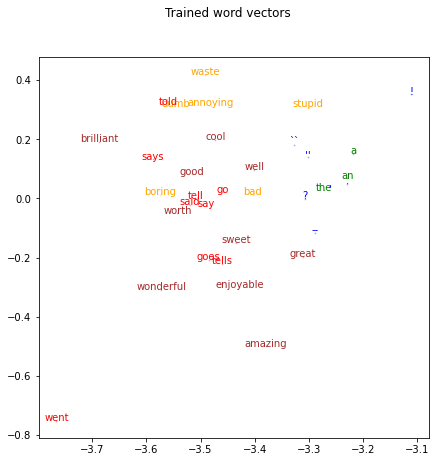

In [10]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)

trained_input_vectors = trained_input_vectors.cpu()
trained_output_vectors = trained_output_vectors.cpu()

assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors)

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")